# Time Series Analysis
## Seasonal ARIMA model

In [1]:
import warnings
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from tqdm import tqdm_notebook

warnings.filterwarnings('ignore')

In [2]:
series = pd.read_csv('data/^GSPC.csv', index_col=['Date'], skiprows=range(1, 2000), usecols=['Date', 'Open'],
                     parse_dates=['Date'])
data = series.Open

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
class SARIMA:
    def __init__(self, series, p, d, q, ps, ds, qs, s):
        self.series = series
        self.p = p
        self.d = d
        self.q = q
        self.ps = ps
        self.ds = ds
        self.qs = qs
        self.s = s

    def parameters_init(self):
        parameters = product(self.p, self.q, self.ps, self.qs)
        parameters_list = list(parameters)
        param_len = len(parameters_list)
        print('Combinations of parameters =', param_len)
        self.parameters_list = parameters_list


    def optimize(self):
        """
            Return dataframe with parameters and corresponding AIC

            parameters_list - list with (p, q, P, Q) tuples
            d - integration order in ARIMA model
            D - seasonal integration order
            s - length of season
        """
        series = self.series
        parameters_list = self.parameters_list
        d = self.d
        D = self.ds
        s = self.s

        results = []
        best_aic = float("inf")

        for param in tqdm_notebook(parameters_list):
            # we need try-except because on some combinations model fails to converge
            try:
                model = sm.tsa.statespace.SARIMAX(series, order=(param[0], d, param[1]),
                                                  seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
            except:
                continue
            aic = model.aic
            # saving best model, AIC and parameters
            if aic < best_aic:
                best_model = model
                best_aic = aic
                best_param = param
            results.append([param, model.aic])

        result_table = pd.DataFrame(results)
        result_table.columns = ['parameters', 'aic']
        # sorting in ascending order, the lower AIC is - the better
        result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

        return result_table

In [5]:
def tsplot(y, lags=None, figsize=(10, 10), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        plt.show()

def plot_results(series, model):
    """
        Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future

    """

    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    data['arima_model'][:s + d] = np.NaN

    forecast = data.arima_model
    error = mean_absolute_percentage_error(data['actual'][s + d:], data['arima_model'][s + d:])

    plt.figure(figsize=(15, 7))
    plt.title("SARIMAX Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()

    plt.grid(True);

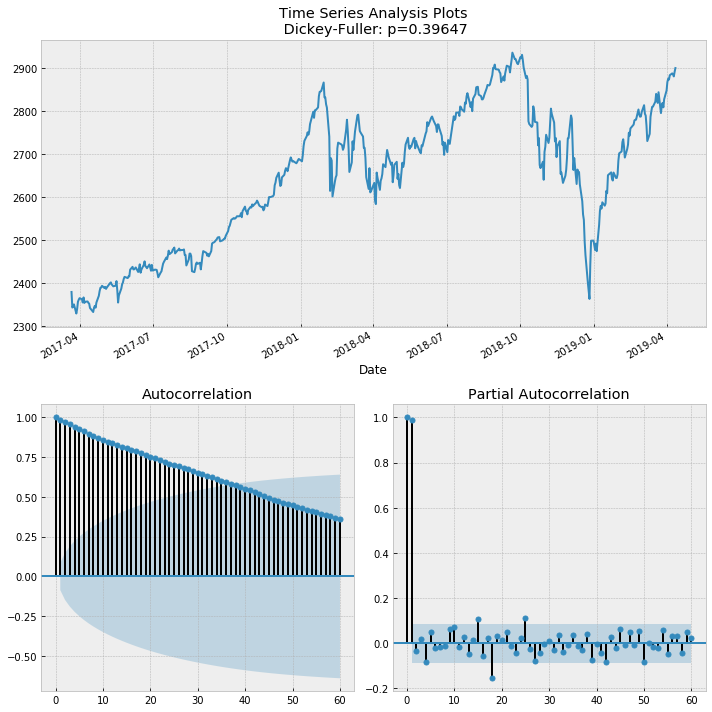

In [6]:
# Run Dickey-Fuller test, examine trend, seasonality
tsplot(series.Open, lags=60)

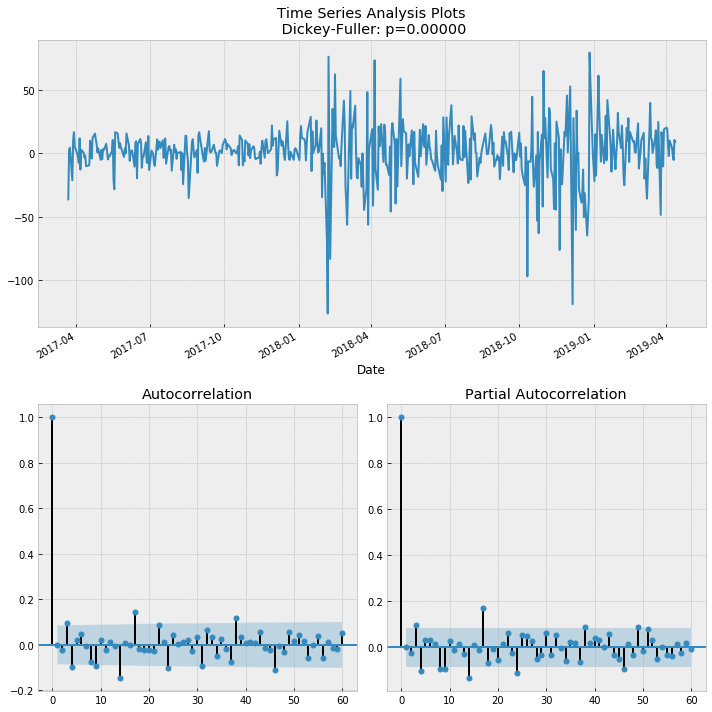

In [7]:
# Apply seasonality lag, remove trend, display results
s = 1  # seasonality - 60 days
data_diff = data - data.shift(s)
tsplot(data_diff[s:], lags=60)

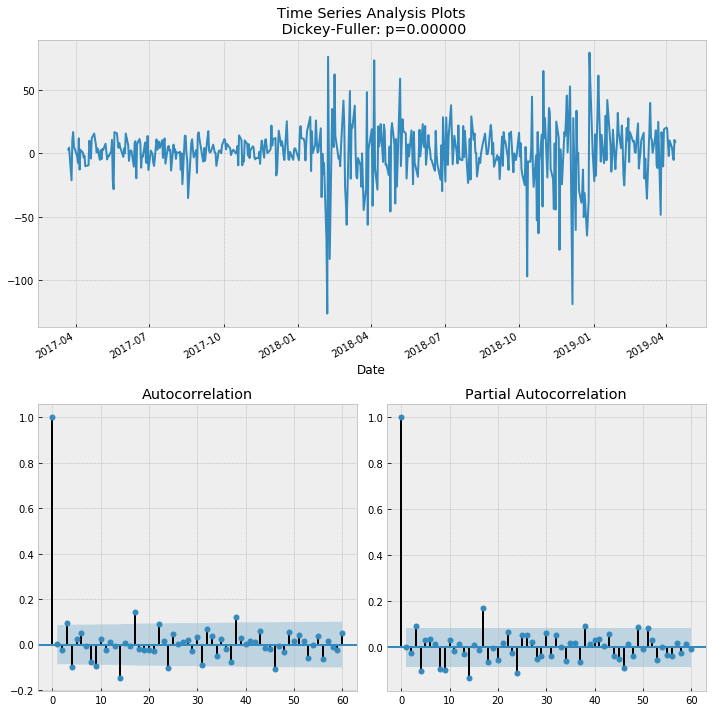

In [8]:
# remove autocorrelation lags
data_diff = data - data.shift(1)
tsplot(data_diff[s+1:], lags=60)

In [9]:
# Initialize parameters of the model
p = range(2, 5)
d = 1  # integration order (0, 1)
q = range(2, 5)

# Seasonality parameters
ps = range(0, 3)
ds = 1
qs = range(0, 3)
s = 1

# Build seasonal ARIMA model
model = SARIMA(data, p, d, q, ps, ds, qs, s)
model.parameters_init()

Combinations of parameters = 81


In [10]:
%%time

# optimize parameters of ARIMA
parameters_opt = model.optimize()
p, q, ps, qs = parameters_opt.parameters[0]
best_model = sm.tsa.statespace.SARIMAX(data, order=(p, d, q),
                                       seasonal_order=(ps, ds, qs, s)).fit(disp=-1)


CPU times: user 2min 52s, sys: 1min 55s, total: 4min 47s
Wall time: 2min 24s


In [11]:
# Save best model configuration
with open('sarima-gspc-54.p', 'wb') as file:
    pickle.dump(best_model, file)

In [12]:
# Optional: Load model
with open('sarima-gspc-54.p', 'rb') as file:
    best_model = pickle.load(file)

In [13]:
# Display model results
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                              Open   No. Observations:                  520
Model:             SARIMAX(2, 1, 3)x(0, 1, 0, 1)   Log Likelihood               -2321.980
Date:                           Mon, 15 Apr 2019   AIC                           4655.960
Time:                                   20:48:20   BIC                           4681.460
Sample:                                        0   HQIC                          4665.951
                                           - 520                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7583      0.019    -92.735      0.000      -1.796      -1.721
ar.L2         -0.9559      0.019    -49.298      0.000      -0.994      -0.918
ma.L1          0.8051      2.620      0.307      0.759      -4.330       5.940
ma.L2         -0.8131      4.728     -0.172      0.863     -10.080       8.454
ma.L3         -0.9919      2.597     -0.382      0.703      -6.082       4.099
sigma2       451.1983   1181.431      0.382      0.703   -1864.364    2766.761
===================================================================================
Ljung-Box (Q):                       68.18   Jarque-Bera (JB):               884.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.09   Skew:                            -0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

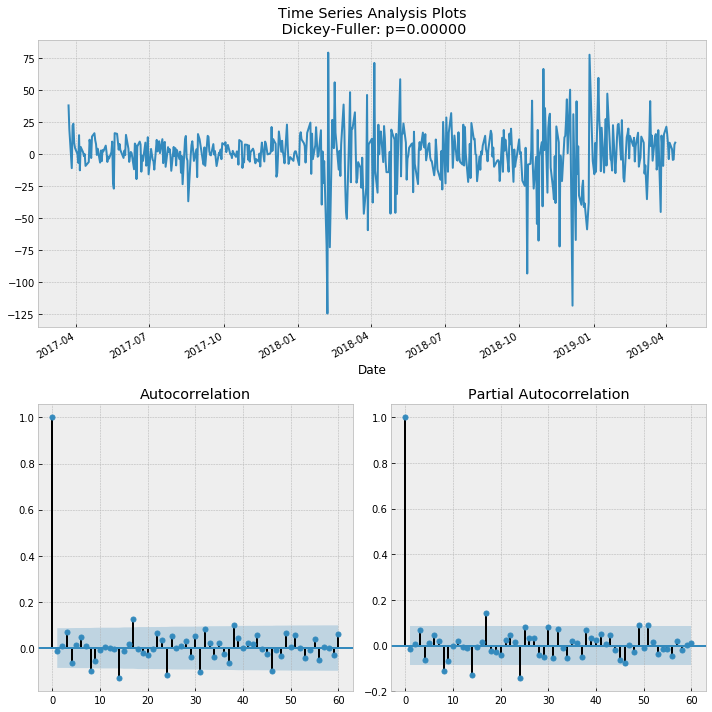

In [14]:
# Plot residuals
tsplot(best_model.resid[s + 1:], lags=60)

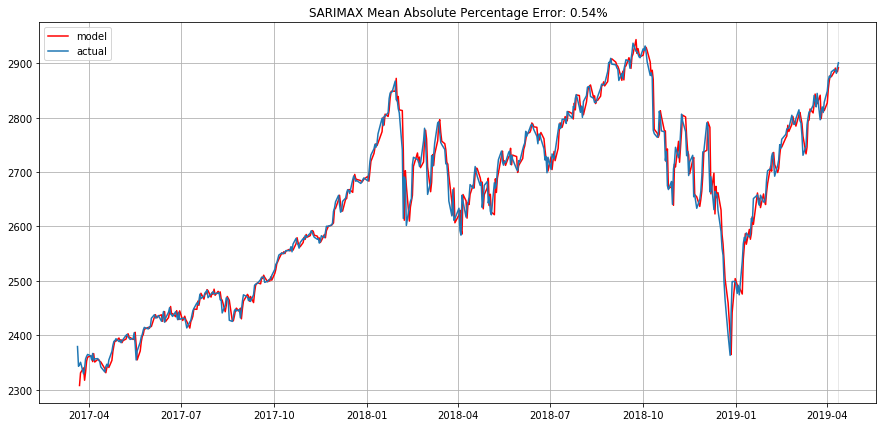

In [15]:
# Make predictions
plot_results(series, model=best_model)

Ref: https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html